<a href="https://colab.research.google.com/github/Boxika/Credit-Defaults-AI/blob/main/XGBoost_Train_and_Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1, 'scale_pos_weight': 1}
Best AUC score:  0.8905540999773762
[0]	validation_0-auc:0.77273
[1]	validation_0-auc:0.78475
[2]	validation_0-auc:0.79101
[3]	validation_0-auc:0.79595
[4]	validation_0-auc:0.80695


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.81059
[6]	validation_0-auc:0.81336
[7]	validation_0-auc:0.81547
[8]	validation_0-auc:0.81818
[9]	validation_0-auc:0.82050
[10]	validation_0-auc:0.82336
[11]	validation_0-auc:0.82721
[12]	validation_0-auc:0.82837
[13]	validation_0-auc:0.82987
[14]	validation_0-auc:0.82998
[15]	validation_0-auc:0.83107
[16]	validation_0-auc:0.83251
[17]	validation_0-auc:0.83381
[18]	validation_0-auc:0.83485
[19]	validation_0-auc:0.83676
[20]	validation_0-auc:0.83767
[21]	validation_0-auc:0.83847
[22]	validation_0-auc:0.84062
[23]	validation_0-auc:0.84145
[24]	validation_0-auc:0.84236
[25]	validation_0-auc:0.84331
[26]	validation_0-auc:0.84404
[27]	validation_0-auc:0.84412
[28]	validation_0-auc:0.84472
[29]	validation_0-auc:0.84548
[30]	validation_0-auc:0.84583
[31]	validation_0-auc:0.84645
[32]	validation_0-auc:0.84790
[33]	validation_0-auc:0.84856
[34]	validation_0-auc:0.84899
[35]	validation_0-auc:0.84963
[36]	validation_0-auc:0.85036
[37]	validation_0-auc:0.85103
[38]	validation

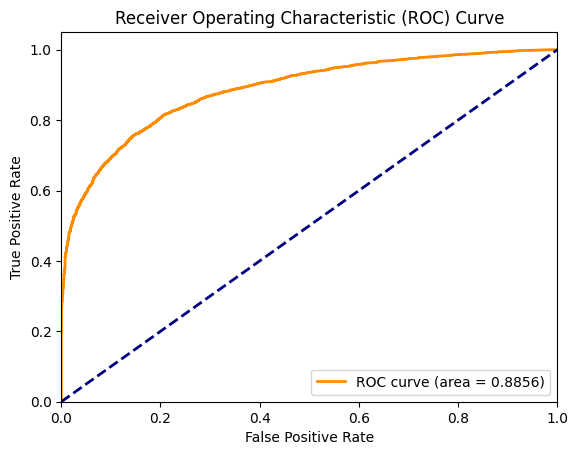

<Figure size 1000x800 with 0 Axes>

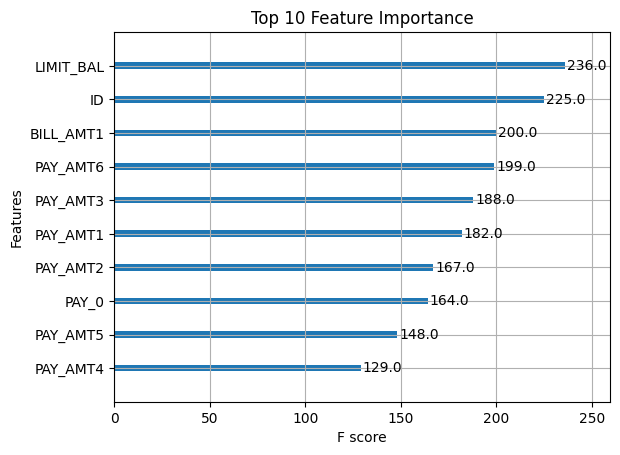

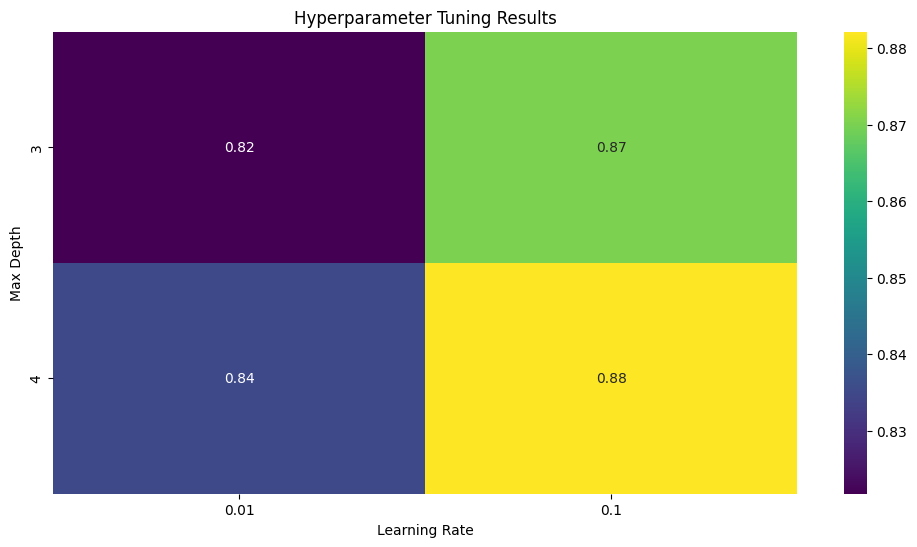

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/VCRK Credit Defaults/Datasets/UCI_Credit_Card.csv'  # Update this path if needed
data = pd.read_csv(file_path)

# Assume 'default.payment.next.month' is the target variable and features are all other columns
X = data.drop(columns=['default.payment.next.month'])
y = data['default.payment.next.month']

# Apply SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_res, y_res, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5,],
    'reg_lambda': [1, 10,],
    'learning_rate': [0.01, 0.1,],
    'max_depth': [3, 4,],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, 2, 2.5]
}

# Initialize the model
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    tree_method='hist'
)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best AUC score: ", grid_search.best_score_)

# Train the best model with early stopping
best_xgb_clf = grid_search.best_estimator_
best_xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    early_stopping_rounds=10,
    verbose=True
)

# Evaluate on training data
y_train_pred = best_xgb_clf.predict(X_train)
y_train_pred_proba = best_xgb_clf.predict_proba(X_train)[:, 1]

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Training Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print(f"Training ROC-AUC Score: {roc_auc_score(y_train, y_train_pred_proba):.4f}")

# Evaluate on validation data
y_val_pred = best_xgb_clf.predict(X_val)
y_val_pred_proba = best_xgb_clf.predict_proba(X_val)[:, 1]

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print(f"Validation ROC-AUC Score: {roc_auc_score(y_val, y_val_pred_proba):.4f}")

# Evaluate on test data
y_test_pred = best_xgb_clf.predict(X_test)
y_test_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print(f"Test ROC-AUC Score: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_score(y_test, y_test_pred_proba))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb_clf, max_num_features=10, importance_type='weight')
plt.title('Top 10 Feature Importance')
plt.show()

# Visualize hyperparameter tuning results
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(values='mean_test_score', index='param_max_depth', columns='param_learning_rate', aggfunc=np.mean)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.title('Hyperparameter Tuning Results')
plt.show()


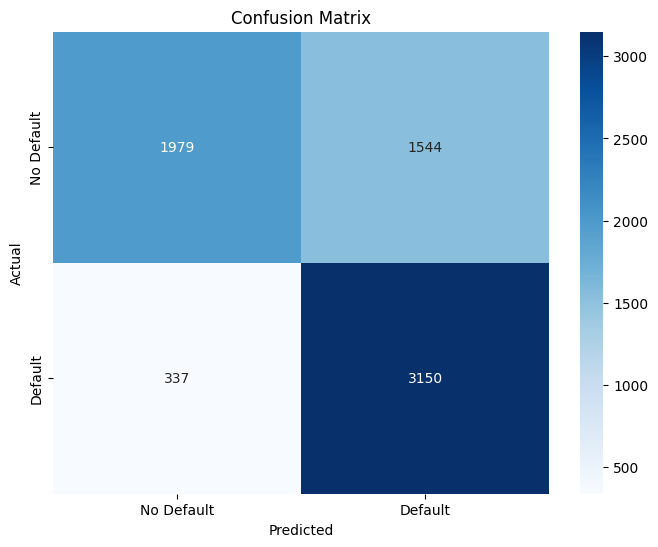

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


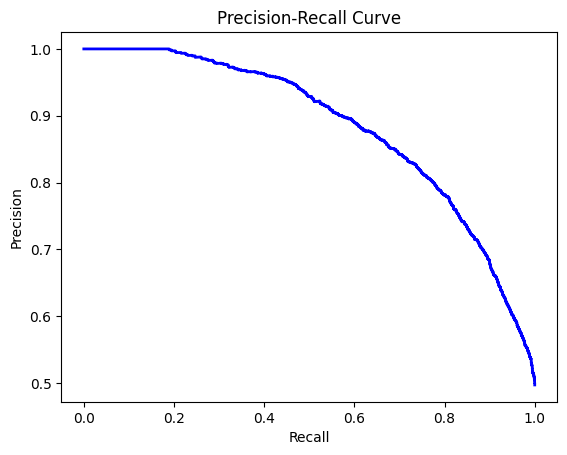

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
import seaborn as sns

results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot('param_n_neighbors', 'param_metric', 'mean_test_score')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.xlabel('Metric')
plt.ylabel('Number of Neighbors')
plt.title('Hyperparameter Tuning Results')
plt.show()


NameError: name 'grid_search' is not defined